In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import auc,roc_curve

from sklearn.externals import joblib
import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler,SMOTE

from random import random

import matplotlib.pyplot as plt
%matplotlib inline

nrow = None
number_of_time = 10

In [3]:
train = pd.read_csv('../data/train.csv',nrows=nrow)
train.drop('ID_code',inplace= True,axis=1)

In [4]:
y = pd.DataFrame(train['target'])
#sc = MinMaxScaler()
x = pd.DataFrame(train.drop('target',axis=1),columns=train.columns[1:])

In [5]:
def data_augmentation(x,y,low_class_ratio = 0.2,method = 'none'):
    if method == 'random_under_sample':
        sm = RandomUnderSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'random_over_sample':
        sm = RandomOverSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'smote':
        sm = SMOTE(sampling_strategy=1-low_class_ratio,m_neighbors=10,kind='svm')
        aug_x,aug_y = sm.fit_resample(x,y)
    else:
        aug_x = x
        aug_y = y
    
    return(pd.DataFrame(aug_x,columns=x.columns),pd.DataFrame(aug_y,columns=['target']))

In [6]:
test = pd.read_csv('../data/test.csv')
sub = pd.DataFrame()
sub['ID_code'] = test['ID_code']
test.drop('ID_code',axis=1,inplace=True)
#test_x = sc.transform(test)
#train,test = train_test_split(train,test_size = 0.3)

In [7]:
train_x = train.drop('target',axis=1).reset_index(drop=True)
train_y = pd.DataFrame(train['target']).reset_index(drop=True)

In [12]:
#predict and combine
def combine_pred(x,y,test_x):
    pred = np.zeros((test.shape[0]))
    for i in range(number_of_time):
        model = k_fold_train(x,y,'none',random()/2)
        pred = pred + model.predict(test_x)

    pred = pred/number_of_time
    return(pred)

In [8]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.003,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial',
    "verbosity" : 1
}
def k_fold_train(x,y,sample_method = 'none',sample_ratio = 0.2):
    kf = StratifiedKFold(n_splits=3)
    
    for train_index,val_index in kf.split(x,y):
        train_model_x,val_model_x = x.iloc[train_index,:],x.iloc[val_index,:]
        train_model_y,val_model_y = y.iloc[train_index],y.iloc[val_index]
        n_x,n_y = data_augmentation(train_model_x,train_model_y,method=sample_method,low_class_ratio=sample_ratio)
        train_data = lgb.Dataset(n_x,n_y)
        val_data = lgb.Dataset(val_model_x,val_model_y)
        
        model = lgb.train(param,train_set=train_data,num_boost_round=100000,verbose_eval = 100,
                          early_stopping_rounds=1000,valid_sets = [train_data,val_data])
        return(model)

In [11]:
base_line = k_fold_train(train_x,train_y)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.871971	valid_1's auc: 0.849574
[200]	training's auc: 0.886763	valid_1's auc: 0.866336
[300]	training's auc: 0.890497	valid_1's auc: 0.86912
[400]	training's auc: 0.892901	valid_1's auc: 0.870857
[500]	training's auc: 0.894976	valid_1's auc: 0.873896
[600]	training's auc: 0.895507	valid_1's auc: 0.874005
[700]	training's auc: 0.896619	valid_1's auc: 0.87528
[800]	training's auc: 0.898246	valid_1's auc: 0.876803
[900]	training's auc: 0.898103	valid_1's auc: 0.876764
[1000]	training's auc: 0.899399	valid_1's auc: 0.877645
[1100]	training's auc: 0.901111	valid_1's auc: 0.879352
[1200]	training's auc: 0.902142	valid_1's auc: 0.880068
[1300]	training's auc: 0.902426	valid_1's auc: 0.880042
[1400]	training's auc: 0.90277	valid_1's auc: 0.880464
[1500]	training's auc: 0.903015	valid_1's auc: 0.880787
[1600]	training's auc: 0.903527	valid_1's auc: 0.881347
[1700]	training's auc: 0.904175	valid_1's auc: 0.881

[14700]	training's auc: 0.934932	valid_1's auc: 0.897393
[14800]	training's auc: 0.935082	valid_1's auc: 0.897426
[14900]	training's auc: 0.935233	valid_1's auc: 0.897448
[15000]	training's auc: 0.935371	valid_1's auc: 0.897473
[15100]	training's auc: 0.935508	valid_1's auc: 0.897493
[15200]	training's auc: 0.935657	valid_1's auc: 0.897533
[15300]	training's auc: 0.935801	valid_1's auc: 0.897551
[15400]	training's auc: 0.935949	valid_1's auc: 0.897581
[15500]	training's auc: 0.936094	valid_1's auc: 0.897601
[15600]	training's auc: 0.936236	valid_1's auc: 0.897629
[15700]	training's auc: 0.93638	valid_1's auc: 0.897668
[15800]	training's auc: 0.936532	valid_1's auc: 0.897698
[15900]	training's auc: 0.936677	valid_1's auc: 0.897717
[16000]	training's auc: 0.936803	valid_1's auc: 0.897731
[16100]	training's auc: 0.936951	valid_1's auc: 0.897769
[16200]	training's auc: 0.937088	valid_1's auc: 0.897805
[16300]	training's auc: 0.937232	valid_1's auc: 0.897827
[16400]	training's auc: 0.93737	

In [13]:
random_under = k_fold_train(train_x,train_y,'random_under_sample')

Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.882779	valid_1's auc: 0.85004
[200]	training's auc: 0.899267	valid_1's auc: 0.869165
[300]	training's auc: 0.905011	valid_1's auc: 0.874664
[400]	training's auc: 0.908458	valid_1's auc: 0.876603
[500]	training's auc: 0.910651	valid_1's auc: 0.879387
[600]	training's auc: 0.912303	valid_1's auc: 0.880763
[700]	training's auc: 0.913389	valid_1's auc: 0.882052
[800]	training's auc: 0.914653	valid_1's auc: 0.883197
[900]	training's auc: 0.914877	valid_1's auc: 0.883295
[1000]	training's auc: 0.916038	valid_1's auc: 0.883979
[1100]	training's auc: 0.917314	valid_1's auc: 0.88533
[1200]	training's auc: 0.91822	valid_1's auc: 0.885874
[1300]	training's auc: 0.918576	valid_1's auc: 0.885948
[1400]	training's auc: 0.918885	valid_1's auc: 0.886222
[1500]	training's auc: 0.919221	valid_1's auc: 0.886443
[1600]	training's auc: 0.919678	valid_1's auc: 0.886674
[1700]	training's auc: 0.920168	valid_1's auc: 0.8869

[14700]	training's auc: 0.953751	valid_1's auc: 0.895463
[14800]	training's auc: 0.953952	valid_1's auc: 0.895463
[14900]	training's auc: 0.954151	valid_1's auc: 0.895468
[15000]	training's auc: 0.954341	valid_1's auc: 0.8955
[15100]	training's auc: 0.954535	valid_1's auc: 0.895506
[15200]	training's auc: 0.954718	valid_1's auc: 0.895512
[15300]	training's auc: 0.954929	valid_1's auc: 0.895504
[15400]	training's auc: 0.955115	valid_1's auc: 0.895526
[15500]	training's auc: 0.955301	valid_1's auc: 0.895555
[15600]	training's auc: 0.955498	valid_1's auc: 0.895546
[15700]	training's auc: 0.955696	valid_1's auc: 0.895564
[15800]	training's auc: 0.955883	valid_1's auc: 0.895573
[15900]	training's auc: 0.956082	valid_1's auc: 0.895592
[16000]	training's auc: 0.956249	valid_1's auc: 0.895577
[16100]	training's auc: 0.956436	valid_1's auc: 0.895584
[16200]	training's auc: 0.956629	valid_1's auc: 0.895596
[16300]	training's auc: 0.956827	valid_1's auc: 0.895601
[16400]	training's auc: 0.95702	v

In [10]:
random_over = k_fold_train(train_x,train_y,'random_over_sample')

/home/weiyi/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.880952	valid_1's auc: 0.856446
[200]	training's auc: 0.894296	valid_1's auc: 0.87122
[300]	training's auc: 0.898047	valid_1's auc: 0.874333
[400]	training's auc: 0.900375	valid_1's auc: 0.876219
[500]	training's auc: 0.902197	valid_1's auc: 0.87833
[600]	training's auc: 0.903197	valid_1's auc: 0.87938
[700]	training's auc: 0.904296	valid_1's auc: 0.880339
[800]	training's auc: 0.905503	valid_1's auc: 0.881559
[900]	training's auc: 0.905649	valid_1's auc: 0.881653
[1000]	training's auc: 0.906661	valid_1's auc: 0.882297
[1100]	training's auc: 0.907716	valid_1's auc: 0.883322
[1200]	training's auc: 0.908542	valid_1's auc: 0.88367
[1300]	training's auc: 0.908857	valid_1's auc: 0.883634
[1400]	training's auc: 0.909205	valid_1's auc: 0.88383
[1500]	training's auc: 0.909512	valid_1's auc: 0.884033
[1600]	training's auc: 0.909895	valid_1's auc: 0.884303
[1700]	training's auc: 0.9104	valid_1's auc: 0.884598


[14700]	training's auc: 0.940969	valid_1's auc: 0.895568
[14800]	training's auc: 0.941143	valid_1's auc: 0.895607
[14900]	training's auc: 0.941322	valid_1's auc: 0.895631
[15000]	training's auc: 0.941495	valid_1's auc: 0.895651
[15100]	training's auc: 0.94167	valid_1's auc: 0.89566
[15200]	training's auc: 0.941853	valid_1's auc: 0.895686
[15300]	training's auc: 0.942025	valid_1's auc: 0.895704
[15400]	training's auc: 0.942202	valid_1's auc: 0.895722
[15500]	training's auc: 0.942377	valid_1's auc: 0.895747
[15600]	training's auc: 0.942535	valid_1's auc: 0.895777
[15700]	training's auc: 0.942706	valid_1's auc: 0.895802
[15800]	training's auc: 0.942881	valid_1's auc: 0.895829
[15900]	training's auc: 0.943057	valid_1's auc: 0.895863
[16000]	training's auc: 0.943212	valid_1's auc: 0.895872
[16100]	training's auc: 0.943386	valid_1's auc: 0.895888
[16200]	training's auc: 0.943557	valid_1's auc: 0.895899
[16300]	training's auc: 0.943733	valid_1's auc: 0.895917
[16400]	training's auc: 0.943891	

[29200]	training's auc: 0.962201	valid_1's auc: 0.897251
[29300]	training's auc: 0.962317	valid_1's auc: 0.897251
[29400]	training's auc: 0.962433	valid_1's auc: 0.897249
[29500]	training's auc: 0.962554	valid_1's auc: 0.89725
[29600]	training's auc: 0.962673	valid_1's auc: 0.897251
[29700]	training's auc: 0.962794	valid_1's auc: 0.897254
[29800]	training's auc: 0.962914	valid_1's auc: 0.897256
[29900]	training's auc: 0.963039	valid_1's auc: 0.897263
[30000]	training's auc: 0.963151	valid_1's auc: 0.897259
[30100]	training's auc: 0.963263	valid_1's auc: 0.897258
[30200]	training's auc: 0.963387	valid_1's auc: 0.897255
[30300]	training's auc: 0.96351	valid_1's auc: 0.89726
[30400]	training's auc: 0.963629	valid_1's auc: 0.897266
[30500]	training's auc: 0.963745	valid_1's auc: 0.897267
[30600]	training's auc: 0.963867	valid_1's auc: 0.897269
[30700]	training's auc: 0.963981	valid_1's auc: 0.897276
[30800]	training's auc: 0.964098	valid_1's auc: 0.897281
[30900]	training's auc: 0.96421	va

In [ ]:
smote = k_fold_train(train_x,train_y,'smote')

/home/weiyi/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [13]:
pred = base_line.predict(test.drop('target',axis=1))

result_df = pd.DataFrame()
result_df['label'] = test['target']
result_df['base'] = pred

In [14]:
pred = random_under.predict(test.drop('target',axis=1))
result_df['random_under'] = pred

pred = random_over.predict(test.drop('target',axis=1))
result_df['random_over'] = pred

pred = smote.predict(test.drop('target',axis=1))
result_df['smote'] = pred

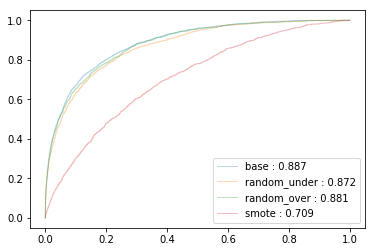

,models,auc_score
0,base,0.886506
1,random_under,0.872042
2,random_over,0.881391
3,smote,0.709319


In [15]:
plotGraph(result_df)

In [13]:
#final_pred = combine_pred(x,y,test)
final_pred = base_line.predict(test)

In [14]:
sub['target'] = final_pred
sub.to_csv("../data/one_round_base_sub.csv",index=False)

In [15]:
final_pred

array([0.13625695, 0.26293197, 0.18565381, ..., 0.00538264, 0.0696702 ,
       0.06835998])